In [364]:
# %load_ext autoreload
# %autoreload 2

import sys
sys.path.append('..')

from events_calc import precip_events
from lib.obs import hourly_precip
from lib.enso import oni_trimonthly

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# suppress warnings
pd.options.mode.chained_assignment = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load hourly precip data for SFO

In [259]:
sfo_precip = hourly_precip('SFO', '1950-07-01', '2021-06-30')

In [205]:
sfo_precip.head()

,station,network,valid,precip_in
0,SFO,CA_ASOS,1950-09-17 19:00:00,0.09
1,SFO,CA_ASOS,1950-09-17 20:00:00,0.02
2,SFO,CA_ASOS,1950-10-17 05:00:00,0.03
3,SFO,CA_ASOS,1950-10-17 15:00:00,0.01
4,SFO,CA_ASOS,1950-10-23 17:00:00,0.01


In [431]:
eps = 12
min_samples = 10
rain_event_labels = precip_events(sfo_precip, eps, min_samples, chunks=50)

In [432]:
sfo_precip_temp = sfo_precip.copy()
sfo_precip_temp['clust'] = rain_event_labels
sfo_precip_temp = sfo_precip_temp[sfo_precip_temp.clust >= 0]

In [433]:
sfo_precip_temp.tail()

,station,network,valid,precip_in,clust
24581,SFO,CA_ASOS,2021-03-18 21:00:00,0.05,1827
24582,SFO,CA_ASOS,2021-03-18 22:00:00,0.01,1827
24583,SFO,CA_ASOS,2021-03-18 23:00:00,0.01,1827
24584,SFO,CA_ASOS,2021-03-19 00:00:00,0.02,1827
24587,SFO,CA_ASOS,2021-06-15 20:00:00,0.57,1828


In [434]:
def calc_past_24_all(df):
    def calc_past_24_row(t):
        t_minus24 = t - pd.Timedelta(24, 'h')
        df_subset = df[(df.valid > t_minus24) & (df.valid <= t)]
        if len(df_subset) == 0:
            return 0
        return df_subset.precip_in.sum()
    return df.apply(lambda row: calc_past_24_row(row.valid), axis=1)

In [435]:
precip_24hr_clust = sfo_precip_temp.groupby('clust', as_index=False).apply(calc_past_24_all)

In [436]:
precip_24hr_clust_id = precip_24hr_clust.reset_index(name='precip_24_hr')['precip_24_hr']
precip_24hr_clust_id.index = sfo_precip_temp.index
sfo_precip_temp['precip_in_24hr']= precip_24hr_clust_id

In [437]:
sfo_precip_temp.tail()

,station,network,valid,precip_in,clust,precip_in_24hr
24581,SFO,CA_ASOS,2021-03-18 21:00:00,0.05,1827,0.12
24582,SFO,CA_ASOS,2021-03-18 22:00:00,0.01,1827,0.13
24583,SFO,CA_ASOS,2021-03-18 23:00:00,0.01,1827,0.14
24584,SFO,CA_ASOS,2021-03-19 00:00:00,0.02,1827,0.16
24587,SFO,CA_ASOS,2021-06-15 20:00:00,0.57,1828,0.57


In [438]:
sfo_rain_events = sfo_precip_temp.groupby('clust', as_index=False).agg({
    'precip_in': sum,
    'valid': [lambda r: pd.Timestamp(np.nanmean([tsp.value for tsp in r])), min, max],
    'precip_in_24hr': max
})
sfo_rain_events.columns.droplevel(level=0)
sfo_rain_events.columns = ['clust', 'precip', 'mean_time', 'min_time', 'max_time', 'max_precip_24hr']

In [439]:
def get_max_precip_hr(precip, clust):
    row = sfo_precip_temp[(sfo_precip_temp.precip_in_24hr == precip) & (sfo_precip_temp.clust == clust)]
    return row.valid.values[0]
    
sfo_rain_events['max_precip_hr'] = sfo_rain_events.apply(lambda r: get_max_precip_hr(r.max_precip_24hr, r.clust), axis=1)

In [440]:
sfo_rain_events.sort_values(by='max_precip_24hr', ascending=False).head(10)

,clust,precip,mean_time,min_time,max_time,max_precip_24hr,max_precip_hr
775,775,6.51,1982-01-04 17:09:05.454545472,1982-01-04 01:00:00,1982-01-05 14:00:00,5.71,1982-01-05 08:00:00
414,414,5.98,1967-01-21 08:30:00.000000000,1967-01-20 12:00:00,1967-01-22 05:00:00,4.58,1967-01-22 03:00:00
316,316,6.94,1962-10-13 02:23:15.918367360,1962-10-11 14:00:00,1962-10-14 05:00:00,3.74,1962-10-14 00:00:00
1680,1680,3.81,2014-12-12 03:45:00.000000000,2014-12-11 13:00:00,2014-12-13 07:00:00,3.54,2014-12-12 10:00:00
1754,1754,3.54,2018-01-08 21:30:00.000000000,2018-01-08 08:00:00,2018-01-09 11:00:00,3.44,2018-01-09 10:00:00
1222,1222,8.16,1998-02-05 00:11:24.000000128,1998-02-01 13:00:00,1998-02-08 23:00:00,3.41,1998-02-03 12:00:00
137,137,5.56,1955-12-23 00:30:31.578947392,1955-12-21 15:00:00,1955-12-24 09:00:00,3.33,1955-12-23 22:00:00
1144,1144,4.22,1995-12-12 00:45:00.000000000,1995-12-11 00:00:00,1995-12-12 19:00:00,3.18,1995-12-12 08:00:00
1064,1064,3.71,1993-01-13 13:05:08.571428608,1993-01-12 18:00:00,1993-01-14 19:00:00,3.00,1993-01-13 22:00:00
1339,1339,3.32,2001-12-02 08:50:16.216216192,2001-12-01 06:00:00,2001-12-03 22:00:00,2.89,2001-12-02 15:00:00


In [441]:
sfo_rain_events.sort_values(by='precip', ascending=False).head(10)

,clust,precip,mean_time,min_time,max_time,max_precip_24hr,max_precip_hr
1222,1222,8.16,1998-02-05 00:11:24.000000128,1998-02-01 13:00:00,1998-02-08 23:00:00,3.41,1998-02-03 12:00:00
316,316,6.94,1962-10-13 02:23:15.918367360,1962-10-11 14:00:00,1962-10-14 05:00:00,3.74,1962-10-14 00:00:00
908,908,6.65,1986-02-16 23:49:40.645161280,1986-02-14 01:00:00,1986-02-20 18:00:00,1.84,1986-02-17 20:00:00
775,775,6.51,1982-01-04 17:09:05.454545472,1982-01-04 01:00:00,1982-01-05 14:00:00,5.71,1982-01-05 08:00:00
414,414,5.98,1967-01-21 08:30:00.000000000,1967-01-20 12:00:00,1967-01-22 05:00:00,4.58,1967-01-22 03:00:00
137,137,5.56,1955-12-23 00:30:31.578947392,1955-12-21 15:00:00,1955-12-24 09:00:00,3.33,1955-12-23 22:00:00
1564,1564,4.99,2010-01-20 19:24:10.000000000,2010-01-17 15:00:00,2010-01-23 20:00:00,1.85,2010-01-19 16:00:00
224,224,4.69,1958-04-03 02:35:10.344827584,1958-04-01 07:00:00,1958-04-04 21:00:00,2.66,1958-04-03 12:00:00
786,786,4.39,1982-03-30 17:10:31.578947392,1982-03-28 09:00:00,1982-04-01 20:00:00,2.46,1982-03-31 20:00:00
1144,1144,4.22,1995-12-12 00:45:00.000000000,1995-12-11 00:00:00,1995-12-12 19:00:00,3.18,1995-12-12 08:00:00


# Look at rainfall distribution of rain events

In [442]:
sfo_rain_events.max_precip_24hr.describe()

count    1829.000000
mean        0.601471
std         0.554392
min         0.100000
25%         0.210000
50%         0.410000
75%         0.800000
max         5.710000
Name: max_precip_24hr, dtype: float64

In [443]:
sfo_rain_events.precip.describe()

count    1829.000000
mean        0.698753
std         0.769774
min         0.100000
25%         0.210000
50%         0.430000
75%         0.880000
max         8.160000
Name: precip, dtype: float64

Text(0, 0.5, 'Count')

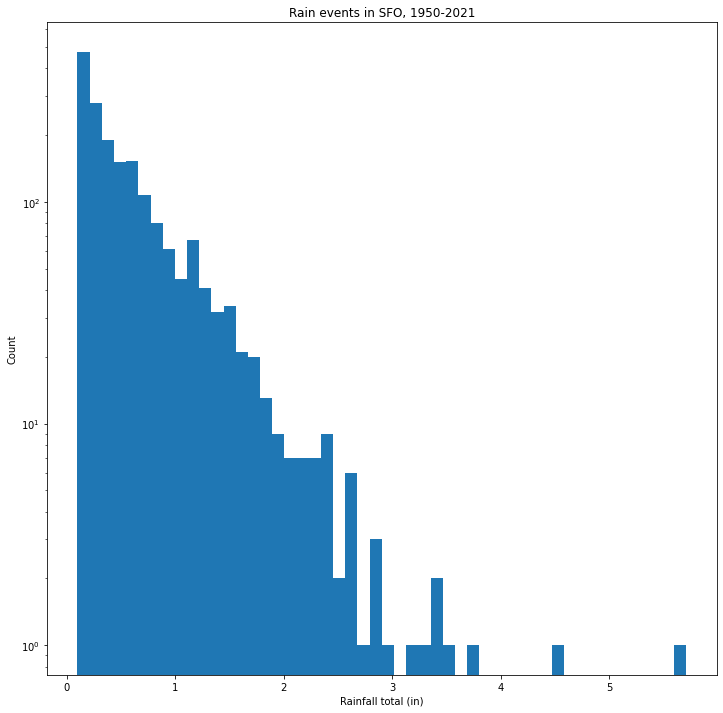

In [444]:
plt.figure(figsize=(12, 12))
plt.hist(sfo_rain_events.max_precip_24hr, bins=50, log=True)
plt.title('Rain events in SFO, 1950-2021')
plt.xlabel('Rainfall total (in)')
plt.ylabel('Count')

# Visualized Clusters

In [570]:
first_date = '2019-01-01 00:00'
last_date = '2019-03-01 00:00'

sfo_precip_plot = hourly_precip('SFO', first_date, last_date, filter_measurable=False)

In [571]:
sfo_precip_plot['precip'] = np.where(sfo_precip_plot['precip_in'] > 0, 1, 0)

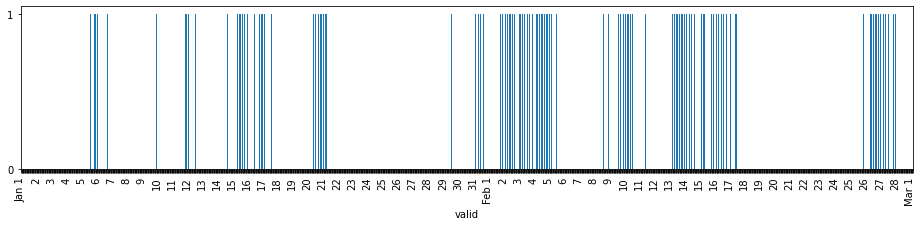

In [572]:
import matplotlib.ticker as ticker

ax = sfo_precip_plot.plot(x='valid', y='precip', kind='bar', figsize=(16, 3), legend=False)
ticklabels = ['']*len(resampled.valid)
ticklabels[::24] = [pd.Timestamp(item).strftime('%-d') for item in resampled.valid.values[::24]]
ticklabels[0] = 'Jan 1'
ticklabels[24*31] = 'Feb 1'
ticklabels[-1] = 'Mar 1'
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.set_yticks([0, 1])
# plt.gcf().autofmt_xdate()

In [573]:
sfo_rain_events[(sfo_rain_events.min_time >= first_date) & (sfo_rain_events.max_time <= last_date)]

,clust,precip,mean_time,min_time,max_time,max_precip_24hr,max_precip_hr
1774,1774,0.19,2019-01-05 19:40:00.000000000,2019-01-05 14:00:00,2019-01-06 04:00:00,0.19,2019-01-06 04:00:00
1775,1775,0.17,2019-01-12 02:50:00.000000000,2019-01-11 22:00:00,2019-01-12 08:00:00,0.17,2019-01-12 08:00:00
1776,1776,1.76,2019-01-16 08:36:25.714285824,2019-01-15 10:00:00,2019-01-17 16:00:00,1.19,2019-01-17 06:00:00
1777,1777,0.28,2019-01-20 22:54:32.727272704,2019-01-20 11:00:00,2019-01-21 09:00:00,0.28,2019-01-21 09:00:00
1778,1778,0.48,2019-01-31 07:15:00.000000000,2019-01-31 03:00:00,2019-01-31 11:00:00,0.48,2019-01-31 11:00:00
1779,1779,1.67,2019-02-03 17:54:13.846153472,2019-02-01 23:00:00,2019-02-05 13:00:00,0.70,2019-02-03 09:00:00
1780,1780,1.05,2019-02-09 22:39:07.826086912,2019-02-08 20:00:00,2019-02-10 14:00:00,0.58,2019-02-10 14:00:00
1781,1781,3.08,2019-02-14 14:33:49.090908928,2019-02-13 03:00:00,2019-02-16 17:00:00,1.71,2019-02-14 10:00:00
1782,1782,0.20,2019-02-17 11:20:00.000000000,2019-02-17 10:00:00,2019-02-17 13:00:00,0.20,2019-02-17 13:00:00
1783,1783,1.18,2019-02-27 04:56:07.741935360,2019-02-26 08:00:00,2019-02-28 02:00:00,0.90,2019-02-28 02:00:00
